In [261]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from PIL import Image
from torchvision.transforms import functional as TF

from sklearn.model_selection import train_test_split


In [262]:
SEED = 0

In [263]:
def read_gz_files(dir, x_file, y_file, image_size, num_images):

    with gzip.open(os.path.join(dir, x_file),'rb') as f:
        f.read(16)
        buf = f.read(image_size * image_size * num_images)
        images = np.copy(np.frombuffer(buf, dtype=np.uint8))
        images = images.reshape(num_images, image_size, image_size)

    with gzip.open(os.path.join(dir, y_file),'rb') as f:
        f.read(8)
        buf = f.read(num_images)
        labels = np.copy(np.frombuffer(buf, dtype=np.uint8))
    
    return images, labels


In [264]:
dir = f'data/MNIST'
train_x_file = 'train-images-idx3-ubyte.gz'
train_y_file = 'train-labels-idx1-ubyte.gz'
test_x_file = 't10k-images-idx3-ubyte.gz'
test_y_file = 't10k-labels-idx1-ubyte.gz'



In [265]:
image_size = 28
np.random.seed(0)

train_images, train_labels = read_gz_files(dir, train_x_file, train_y_file, image_size, num_images=60000)
test_images, test_labels = read_gz_files(dir, test_x_file, test_y_file, image_size, num_images=10000)

In [266]:
def rotate(dataset, rotation_angle):
    images = []
    for img in dataset:
        img = Image.fromarray(img)
        # Apply rotation transformation using torchvision's functional API
        rotated_img = TF.rotate(img, rotation_angle)
        # Convert to numpy array and store
        images.append(np.array(rotated_img))  # Convert tensor to numpy array
    return np.array(images)

In [267]:
def balance(images, labels):
    uniques, counts = np.unique(labels, return_counts=True)
    min_count = min(counts)

    out_imgs = []
    out_lbls = []
    for label in uniques:
        imgs = images[np.where(labels == label)]
        imgs = imgs[:min_count]
        lbls = labels[np.where(labels == label)]
        lbls = lbls[:min_count]
        out_imgs.append(imgs)
        out_lbls.append(lbls)
    out_imgs = np.concatenate(out_imgs, axis=0)
    out_lbls = np.concatenate(out_lbls, axis=0)
    indices = np.random.permutation(len(out_imgs))
    return out_imgs[indices], out_lbls[indices]

In [268]:
def split_balanced(images, labels, n_splits=10):
    # Find unique labels
    unique_labels = np.unique(labels)
    
    # Initialize empty lists to hold the splits
    split_images = [[] for _ in range(n_splits)]
    split_labels = [[] for _ in range(n_splits)]
    
    # For each label, split the images into `n_splits` equal parts
    for label in unique_labels:
        # Get images corresponding to the current label
        label_images = images[labels == label]
        np.random.shuffle(label_images) # shuffle the images for randomness

        # Determine the number of images per split for this label
        split_size = len(label_images) // n_splits
        
        # Split the label's images into `n_splits` parts
        for i in range(n_splits):
            start_idx = i * split_size
            end_idx = (i + 1) * split_size if i < n_splits - 1 else len(label_images)
            split_images[i].append(label_images[start_idx:end_idx])
            split_labels[i].append(np.full(end_idx - start_idx, label))

    # Convert lists of arrays into numpy arrays and shuffle each subset
    for i in range(n_splits):
        split_images[i] = np.concatenate(split_images[i], axis=0)
        split_labels[i] = np.concatenate(split_labels[i], axis=0)
        
        # Shuffle the images and labels together
        indices = np.random.permutation(len(split_images[i]))
        split_images[i] = split_images[i][indices]
        split_labels[i] = split_labels[i][indices]
        
    return split_images, split_labels

In [269]:
def save_data(images, labels, dir, name, split, center):

    save_as = f"{name.lower()}_{split}_{center}.npz"
    np.savez(os.path.join(dir, save_as), 
                images=images,
                labels=labels)



In [270]:
def shuffle(images, labels):
    n_samples = len(labels)
    shuffled_indices = np.random.permutation(n_samples)

    labels = labels[shuffled_indices]
    images = images[shuffled_indices]

    return images, labels


In [271]:
dest_dir = 'data/MNIST/rotmnistmax25c'
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
else:
    print("Warning, existing files might be overwritten")

rot_groups = [0, 90, 180, 270] # max
# rot_groups = [0, 0, 0, 0] # no
# rot_groups = [-3, -1, 1, 3] # min
# rot_groups = [-3, 3, 177, 183] # two
centers_per_group = 25

num_centers = len(rot_groups) * centers_per_group

train_images, train_labels = balance(train_images, train_labels)
print(train_images.shape)
print(train_labels.shape)
test_images, test_labels = balance(test_images, test_labels)

shuffled_trains = [(shuffle(train_images, train_labels)) for _ in range(len(rot_groups))]
shuffled_tests = [(shuffle(test_images, test_labels)) for _ in range(len(rot_groups))]

# with the split train and test, apply rotation to each split
val_split = 0.1

for i, rot in enumerate(rot_groups):
    train_images, train_labels = shuffled_trains[i]
    test_images, test_labels = shuffled_tests[i]
    split_train_images, split_train_labels = split_balanced(train_images, train_labels, centers_per_group)
    split_test_images, split_test_labels = split_balanced(test_images, test_labels, num_centers)

    for j in range(centers_per_group):
        center_train_images = rotate(split_train_images[j], rot)
        center_train_labels = split_train_labels[j]

        X_train, X_val, y_train, y_val = train_test_split(center_train_images, center_train_labels, test_size=val_split, random_state=SEED)
        
        center_num = i * centers_per_group + j
        
        save_data(X_train, y_train, dest_dir, "rotmnist", "train", center_num)
        save_data(X_val, y_val, dest_dir, "rotmnist", "val", center_num)

        center_test_images = rotate(split_test_images[j], rot)
        center_test_labels = split_test_labels[j]
        save_data(center_test_images, center_test_labels, dest_dir, "rotmnist", "test", center_num)
        print("center:", center_num, "train", len(y_train), "val", len(y_val), "test", len(center_test_labels))


(54210, 28, 28)
(54210,)
center: 0 train 1944 val 216 test 80
center: 1 train 1944 val 216 test 80
center: 2 train 1944 val 216 test 80
center: 3 train 1944 val 216 test 80
center: 4 train 1944 val 216 test 80
center: 5 train 1944 val 216 test 80
center: 6 train 1944 val 216 test 80
center: 7 train 1944 val 216 test 80
center: 8 train 1944 val 216 test 80
center: 9 train 1944 val 216 test 80
center: 10 train 1944 val 216 test 80
center: 11 train 1944 val 216 test 80
center: 12 train 1944 val 216 test 80
center: 13 train 1944 val 216 test 80
center: 14 train 1944 val 216 test 80
center: 15 train 1944 val 216 test 80
center: 16 train 1944 val 216 test 80
center: 17 train 1944 val 216 test 80
center: 18 train 1944 val 216 test 80
center: 19 train 1944 val 216 test 80
center: 20 train 1944 val 216 test 80
center: 21 train 1944 val 216 test 80
center: 22 train 1944 val 216 test 80
center: 23 train 1944 val 216 test 80
center: 24 train 2133 val 237 test 80
center: 25 train 1944 val 216 test 

In [272]:
duplicated_rot_groups = [group for group in rot_groups for _ in range(centers_per_group)]

log = [rot for rot in duplicated_rot_groups]
with open(os.path.join(dest_dir, "log.txt"), "w") as f:
    f.write(str(log))

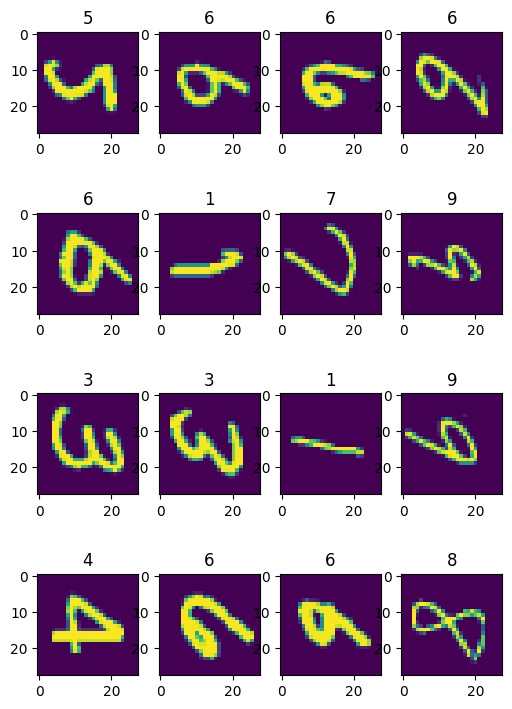

In [273]:
imgs = center_train_images
lbls = center_train_labels 
fig, ax = plt.subplots(4, 4, figsize=(6,9))

for idx in range(16):
    row = idx // 4
    col = idx % 4
    ax[row][col].imshow(imgs[idx])
    ax[row][col].set_title(lbls[idx])